In [93]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split
import skimage as sk
from skimage.morphology import remove_small_objects, remove_small_holes
from scipy import misc

import cv2
from pylab import *
import torch
import torchvision
from torch import nn
from pathlib import Path
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision import models
from torch import optim
from torch.utils.data import Dataset, DataLoader

import lovasz_losses as L
import time
from tqdm import tqdm_notebook as tqdm

In [13]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose
)

In [14]:
work_path = "/media/kaichou/SAMSUNG/hackathon/pa_segface"

In [15]:
train_img_path = work_path + "/train"
train_mask_path = work_path + "/train_mask"
test_path = work_path + "/test"

In [16]:
train_amount = 1491
test_amount = 2177

def upsample(img, mask, arg = 0):
    
    img_stack_1 = np.zeros((320, 136, 3))
    img_stack_2 = np.zeros((96, 512, 3))
    mask_stack_1 = np.zeros((320, 136))
    mask_stack_2 = np.zeros((96, 512))
    
    img = np.hstack((img_stack_1, img))
    img = np.hstack((img, img_stack_1))
    img = np.vstack((img_stack_2, img))
    img = np.vstack((img, img_stack_2))
    img = img.astype(uint8)
    if arg != 0:
        return img
    
    mask = np.hstack((mask_stack_1, mask))
    mask = np.hstack((mask, mask_stack_1))
    mask = np.vstack((mask_stack_2, mask))
    mask = np.vstack((mask, mask_stack_2))
    
    mask = mask.astype(uint8)
    
    return img, mask

def downsample(mask):
    
    mask = np.delete(mask, slice(0, 96), 0)
    mask = np.delete(mask, slice(511- 96 * 2, 511 - 96), 0)
    mask = np.delete(mask, slice(0, 136), 1)
    mask = np.delete(mask, slice(511 - 136 * 2, 511 - 136), 1)
    
    return mask

In [17]:
img_size_target = 256
def upsample(img):
    return cv2.resize(img, (img_size_target, img_size_target))
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
img_x = 240
img_y = 320
def downsample(img):
    return cv2.resize(img, (img_x, img_y))
    #return img[:img_size_ori, :img_size_ori]

In [18]:
train_x = [f"{i}" for i in range(1, train_amount + 1)]
train_y = [f"{i}" for i in range(1, train_amount + 1)]

In [19]:
train_x = np.array(train_x)
train_y = np.array(train_y)

In [20]:
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.2, random_state = 43)

In [21]:
def strong_aug(p=0.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)

In [22]:
img1 = sk.io.imread(os.path.join(train_img_path, "1.jpg"))
mask1 = sk.io.imread(os.path.join(train_mask_path, "1.png"))

In [23]:
np.shape(np.squeeze(np.expand_dims(mask1, 2)))

(320, 240)

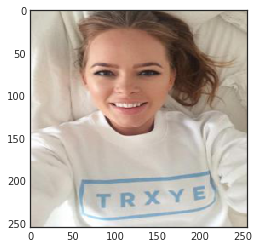

In [24]:
plt.imshow(cv2.resize(img1, (256, 256)))

In [25]:
pr = torch.from_numpy(np.expand_dims(mask1, 2))

In [26]:
torch.cuda.is_available()

True

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x




class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class AlbuNet(nn.Module):
    """
        UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder

        Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/

        """

    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.resnet34(pretrained=pretrained)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec0), dim=1)
        else:
            x_out = self.final(dec0)

        return x_out
    
def albunet(pretrained = False, **kwargs):

    model = AlbuNet(pretrained = pretrained)

    return model


In [29]:
def get_model():
    model = albunet(pretrained=True)
    model.train()
    return model.to(device)

In [30]:
def hwc_to_chw(img):
    return np.transpose(img, axes=[2, 0, 1])
def chw_to_hwc(img):
    return np.transpose(img, axes=[1, 2, 0])

In [31]:
class PeopleDataset(Dataset):
    
    def __init__(self, ids):
        
        self.len = len(ids)
        self.list_IDs = ids
        

    def __len__(self):
        return self.len
        
    def __getitem__(self, index):
        
        ID = self.list_IDs[index]
        
        x = plt.imread(os.path.join(train_img_path, f"{ID}.jpg"))
        y = plt.imread(os.path.join(train_mask_path, f"{ID}.png"))
        
        x = upsample(x)
        y = upsample(y)
        
        augmentatioins = strong_aug(p=0.7)
        augmented = augmentatioins(image = x, mask = y)
        x = augmented["image"]
        y = augmented["mask"]
        
        y = np.expand_dims(y, axis = 2)
        
        x = torch.from_numpy(x)
        x = hwc_to_chw(x.float())
        y = torch.from_numpy(y)
        y = hwc_to_chw(y.float())
        
        return x, y

In [32]:
train_dataset = PeopleDataset(x_train)

In [33]:
valid_dataset = PeopleDataset(x_val)

In [34]:
model = get_model()
model = model.cuda()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/kaichou/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 19706375.35it/s]


In [35]:
from torch.autograd import Function, Variable

class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)

def eval_net(net, dataset_loader, lenin):
    """Evaluation without the densecrf with the dice coefficient"""
    net.eval()
    tot = 0
    
    criterion = nn.BCEWithLogitsLoss()
    
    for x, y in dataset_loader:
        x = x.cuda()
        y = y.cuda()
        
        mask_pred = net(x)
        mask_probs = torch.sigmoid(mask_pred)
        mask_probs_flat = mask_probs.view(-1)
        true_mask_flat = y.view(-1)
        loss = criterion(mask_probs_flat, true_mask_flat)
        
        tot += loss.item()
        
    return tot / lenin

In [36]:
def dice(true, pred):
    true = true.astype(bool)
    pred = pred.astype(bool)

    intersection = (true & pred).sum()
    im_sum = true.sum() + pred.sum()

    return 2.0 * intersection / (im_sum + EPS)


def dice_all(true, pred):
    return np.mean([dice(t, p) for t, p in zip(true, pred)])

In [37]:
def train_model(net, train_dataset, valid_dataset,
                epochs=200, batch_size=32, lr=0.01, save_cp=True, opti = "sgd"):
    if opti == "adam":
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0005)
    elif opti == "sgd":
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
        
    dir_checkpoint = 'checpoints_last/'
    criterion = nn.BCEWithLogitsLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=250)
    
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, num_workers=4)
    valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size, num_workers=4)
    N_train = train_dataset.len
    N_valid = valid_dataset.len
    for epoch in tqdm(range(epochs)):
        epo_time = time.time()
        scheduler.step()
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        net.train()
        epoch_loss = 0
        for x, y in train_loader:
            x = x.cuda()
            y = y.cuda()
            mask_pred = net(x)
            mask_probs = torch.sigmoid(mask_pred)
            mask_probs_flat = mask_probs.view(-1)
                
            true_mask_flat = y.view(-1)
                    
            loss = criterion(mask_probs_flat, true_mask_flat)
                
            epoch_loss += loss.item()
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print('Epoch finished ! Loss: {}'.format(epoch_loss / N_train))
        
            
        if 1:
            val_dice = eval_net(net, valid_loader, N_valid)
            print('Validation loss: {}'.format(val_dice))
    
        if epoch % 20 == 0:
            torch.save(net.state_dict(),
                        dir_checkpoint + 'CP{}.pth'.format(epoch + 1))
            print('Checkpoint {} saved !'.format(epoch + 1))
            
        epo_time = time.time() - epo_time
        print(f"Epoch time: {epo_time}")

def train_model_lovasz(net, train_dataset, valid_dataset, 
                epochs=200, batch_size=32, lr=0.01, save_cp=True, opti = "adam"):
    if opti == "adam":
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0005)
    elif opti == "sgd":
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
        
    dir_checkpoint = 'checkpoints_lovasz_next/'
        
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=150)
    
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, num_workers=4)
    valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size, num_workers=4)
    N_train = train_dataset.len
    N_valid = valid_dataset.len
    for epoch in tqdm(range(epochs)):
        epo_time = time.time()
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        net.train()
        epoch_loss = 0
        for x, y in train_loader:
            x = x.cuda()
            y = y.cuda()
            mask_pred = net(x)
            mask_probs = F.sigmoid(mask_pred)
            mask_probs_flat = mask_probs.view(-1)
                
            true_mask_flat = y.view(-1)
                    
            loss = L.lovasz_hinge_flat(mask_probs_flat, true_mask_flat)
                
            epoch_loss += loss.item()
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print('Epoch finished ! Loss: {}'.format(epoch_loss / N_train))
        
            
        if 1:
            val_dice = eval_net(net, valid_loader, N_valid)
            print('Validation loss: {}'.format(val_dice))
    
        if epoch % 20 == 0:
            torch.save(net.state_dict(),
                        dir_checkpoint + 'CP{}.pth'.format(epoch + 1))
            print('Checkpoint {} saved !'.format(epoch + 1))
        epo_time = time.time() - epo_time 
        print(f"Epoch time: {epo_time}")

In [71]:
train_model(model, train_dataset=train_dataset, valid_dataset=valid_dataset, epochs = 601, batch_size=27, lr = 0.01)

Starting epoch 1/601.


/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch finished ! Loss: 0.018030168501122684
Validation loss: 0.01942545783559614
Checkpoint 1 saved !
Epoch time: 36.875168561935425
Starting epoch 2/601.
Epoch finished ! Loss: 0.018014634440609273
Validation loss: 0.01943149574624256
Epoch time: 39.13166785240173
Starting epoch 3/601.
Epoch finished ! Loss: 0.018023368946257855
Validation loss: 0.0193904788797117
Epoch time: 38.83082723617554
Starting epoch 4/601.
Epoch finished ! Loss: 0.018019429939305224
Validation loss: 0.01936029460916551
Epoch time: 39.177939653396606
Checkpoint 601 saved !
Epoch time: 36.181509256362915


In [594]:
train_model_lovasz(model, train_dataset=train_dataset, valid_dataset=valid_dataset, epochs=1, batch_size=27, opti="sgd")

Starting epoch 1/1.


/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch finished ! Loss: 0.016547440282450428
Validation loss: 0.010154266570722778
Checkpoint 1 saved !
Epoch time: 34.41143822669983


In [348]:
chekpoint = torch.load("./checpoints_last/CP141.pth")

In [349]:
model.load_state_dict(chekpoint)

# Проверочка

In [350]:
model = model.eval()

In [359]:
tutu = str(1515)

In [360]:
test1 = plt.imread(os.path.join(test_path,f"{tutu}.jpg"))
test1_mk = plt.imread(os.path.join(test_path,f"{tutu}.jpg"))
test2_mk= plt.imread(os.path.join(test_path,f"{tutu}.jpg"))

In [361]:
test1= upsample(test1)

In [362]:
test1 = hwc_to_chw(test1)

In [363]:
test1 = np.expand_dims(test1, axis = 0)

In [364]:
test1 = torch.from_numpy(test1)

In [365]:
test1 = test1.float()

In [366]:
test1 = test1.cuda()

In [367]:
pred_msk = model(test1)
pred_msk2 = model(test1)

In [368]:
pred_msk = torch.sigmoid(pred_msk)

In [369]:
pred_msk = pred_msk.cpu()

In [370]:
threshold = 0.25

In [371]:
pred_msk = chw_to_hwc(pred_msk[0].detach().numpy())
pred_msk = downsample(np.squeeze(pred_msk))
pred_msk = remove_small_holes(remove_small_objects(pred_msk > threshold))
pred_msk2 = pred_msk2.cpu()
pred_msk2 = chw_to_hwc(pred_msk2[0].detach().numpy())

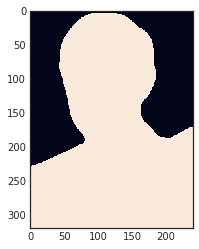

In [372]:
plt.imshow(np.squeeze(pred_msk))

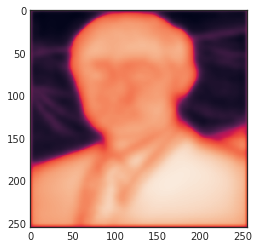

In [373]:
plt.imshow(np.squeeze(pred_msk2))

In [374]:
pred_msk[pred_msk > 0.65] = 1
pred_msk[pred_msk <= 0.65] = 0

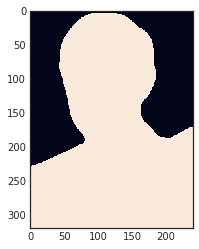

In [375]:
plt.imshow(pred_msk)

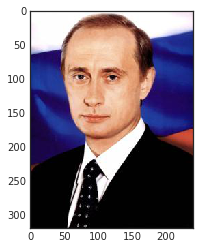

In [376]:
plt.imshow(test2_mk)

In [377]:
np.shape(tt[1][1])

(4,)

In [378]:
tt = test1_mk
tt.setflags(write=1)
for i in range(320):
    for j in range(240):
        if pred_msk[i][j] == 0:
            tt[i][j][0] = 0
            tt[i][j][1] = 0
            tt[i][j][2] = 0

In [379]:
tt = np.dstack((tt, pred_msk * 1000))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


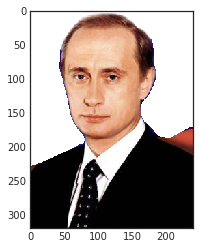

In [380]:
plt.imshow(tt)

In [268]:
plt.imsave("test1.png" , tt)
plt.imsave("test11.png",test2_mk)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [346]:
plt.imsave("test2221.png",np.squeeze(pred_msk2))

# Тест

In [158]:
submission = pd.read_csv("sample_submission.csv")

In [159]:
class PeopleTestDataset(Dataset):
    
    def __init__(self, ids):
        
        self.len = len(ids)
        self.list_IDs = ids
        

    def __len__(self):
        return self.len
        
    def __getitem__(self, index):
        
        ID = self.list_IDs[index]
        
        x = plt.imread(os.path.join(test_path, f"{ID}.jpg"))
        
        x = upsample(x)
        
        
        x = torch.from_numpy(x)
        x = hwc_to_chw(x.float())
        
        return x

In [160]:
test_dataset = PeopleTestDataset(submission["image"])

In [161]:
test_masks = []

In [162]:
threshold = 0.25
def test_work(net, dataset, batch_size = 7):
    net.eval()
    test_loader = DataLoader(dataset = dataset, batch_size = batch_size)
    for x in tqdm(test_loader):
        x = x.float().cuda()
        mask = net(x)
        mask = F.sigmoid(mask)
        for i in mask.cpu():
            i = i.detach().numpy()
            i = chw_to_hwc(i)
            i = downsample(i)
            i = np.squeeze(i)
            i = remove_small_holes(remove_small_objects(i > threshold))
            i[i > 0.5] = 1
            i[i <= 0.5] = 0
            test_masks.append(i)

In [190]:
test_work(model, test_dataset)

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [164]:
submission = submission.drop("rle_mask", 1)

In [165]:
submission["rle_mask"] = test_masks

In [166]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

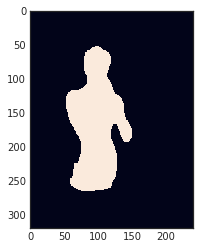

In [192]:
plt.imshow(test_masks[3])

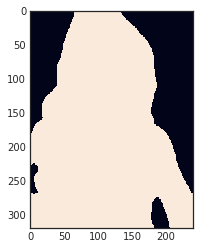

In [167]:
plt.imshow(test_masks[1])

In [168]:
submission.rle_mask = submission.rle_mask.apply(rle_encode)

In [169]:
submission.to_csv("sub.csv", index=False)